In [2]:
import os, nltk
import numpy as np
import pandas as pd

# Data Retrieval

In [3]:
import urllib.request

url = 'https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'
filename = 'nips12raw_str602'
urllib.request.urlretrieve(url, filename)

('nips12raw_str602', <http.client.HTTPMessage at 0x7f86860fb490>)

In [4]:
!tar -xzf nips12raw_str602

In [5]:
DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['orig', 'nips06', 'nips08', 'nips00', 'nips04', 'idx', 'nips02', 'README_yann', 'nips10', 'nips11', 'nips01', 'nips03', 'nips09', 'nips12', 'nips07', 'MATLAB_NOTES', 'nips05', 'RAW_DATA_NOTES']


# Load and View Dataset

In [6]:
folders = ['nips{0:02}'.format(i) for i in range(0, 13)]
# Read all texts into a list
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:#seperate 'em with /
            data = f.read()
        papers.append(data)
len(papers)        

1740

 However, it looks like the OCR hasn’t worked perfectly and we have
some missing characters here and there. This is expected, but also makes this task more
challenging!

In [7]:
print(papers[0][:1000])

804 
INTRODUCTION TO A SYSTEM FOR IMPLEMENTING NEURAL NET 
CONNECTIONS ON SIMD ARCHITECTURES 
Sherryl Tomboulian 
Institute for Computer Applications in Science and Engineering 
NASA Langley Research Center, Hampton VA 23665 
ABSTRACT 
Neural networks have attracted much interest recently, and using parallel 
architectures to simulate neural networks is a natural and necessary applica- 
tion. The SIMD model of parallel computation is chosen, because systems of 
this type can be built with large numbers of processing elements. However, 
such systems are not naturally suited to generalized communication. A method 
is proposed that allows an implementation of neural network connections on 
massively parallel SIMD architectures. The key to this system is an algorithm 
that allows the formation of arbitrary connections between the 'neurons '. A 
feature is the ability to add new connections quickly. It also has error recov- 
ery ability and is robust over a variety of network topologies. Si

# Basic Text Wrangling

In [8]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')#any word
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]# word tokenization
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers

In [9]:
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740


In [10]:
# Viewing a processed paper
print(norm_papers[0][:50])

['introduction', 'system', 'implementing', 'neural', 'net', 'connection', 'simd', 'architecture', 'sherryl', 'tomboulian', 'institute', 'computer', 'application', 'science', 'engineering', 'nasa', 'langley', 'research', 'center', 'hampton', 'va', 'abstract', 'neural', 'network', 'attracted', 'much', 'interest', 'recently', 'using', 'parallel', 'architecture', 'simulate', 'neural', 'network', 'natural', 'necessary', 'applica', 'tion', 'simd', 'model', 'parallel', 'computation', 'chosen', 'system', 'type', 'built', 'large', 'number', 'processing', 'element']


We are now ready to start building topic models

Without further ado, let’s get started by looking at ways to generate phrases with
influential bi-grams and remove some terms that may not be useful before feature
engineering.

# Text Representation with Featuer Engineering

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms

In [12]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter='_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['introduction', 'system', 'implementing', 'neural_net', 'connection', 'simd', 'architecture', 'sherryl', 'tomboulian', 'institute', 'computer', 'application', 'science_engineering', 'nasa', 'langley', 'research_center', 'hampton', 'va', 'abstract', 'neural_network', 'attracted', 'much', 'interest', 'recently', 'using', 'parallel', 'architecture', 'simulate', 'neural_network', 'natural', 'necessary', 'applica', 'tion', 'simd', 'model', 'parallel', 'computation', 'chosen', 'system', 'type', 'built', 'large', 'number', 'processing', 'element', 'however', 'system', 'naturally', 'suited', 'generalized']


Let’s generate phrases for all our tokenized research papers and build a vocabulary
that will help us obtain a unique term/phrase to number mapping

In [13]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representationi of the docuemnts:
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings: ', list(dictionary.items())[:15])
print('Total Vocabulary Size: ', len(dictionary))

Sample word to number mappings:  [(0, '8o6'), (1, 'a2'), (2, 'aasp'), (3, 'ability'), (4, 'able'), (5, 'abstract'), (6, 'aca'), (7, 'according'), (8, 'achieve'), (9, 'achieved'), (10, 'acm'), (11, 'act'), (12, 'activate'), (13, 'activated'), (14, 'active')]
Total Vocabulary Size:  78892


we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper

Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this

In [14]:
# fitler out words that occur less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size: ', len(dictionary))

Total Vocabulary Size:  7756


We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

**We can now perform feature engineering by leveraging a simple Bag of Words
model.**

In [15]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(1, 2), (2, 7), (3, 1), (4, 3), (12, 1), (14, 1), (15, 1), (17, 2), (18, 1), (19, 1), (30, 2), (31, 2), (35, 1), (36, 1), (43, 1), (45, 1), (54, 1), (61, 3), (62, 2), (75, 3), (81, 20), (85, 1), (87, 2), (91, 1), (94, 1), (110, 1), (111, 1), (112, 1), (116, 25), (123, 2), (124, 2), (127, 1), (128, 1), (138, 1), (145, 5), (146, 1), (147, 12), (148, 1), (149, 1), (153, 5), (154, 5), (158, 1), (165, 2), (173, 1), (183, 1), (184, 4), (188, 2), (193, 5), (202, 2), (203, 1)]


In [16]:
# Viewing actual terms and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 2), ('able', 7), ('abstract', 1), ('according', 3), ('activity', 1), ('add', 1), ('added', 1), ('addition', 2), ('additional', 1), ('address', 1), ('allow', 2), ('allows', 2), ('always', 1), ('american_institute', 1), ('appears', 1), ('application', 1), ('arranged', 1), ('assume', 3), ('assumed', 2), ('behavior', 3), ('bit', 20), ('bounded', 1), ('brain', 2), ('build', 1), ('called', 1), ('choosing', 1), ('chosen', 1), ('class', 1), ('code', 25), ('communication', 2), ('competitive', 2), ('complex', 1), ('complexity', 1), ('conclusion', 1), ('connected', 5), ('connecting', 1), ('connection', 12), ('consecutive', 1), ('consider', 1), ('constant', 5), ('constraint', 5), ('contain', 1), ('correct', 2), ('currently', 1), ('design', 1), ('designed', 4), ('determined', 2), ('difficult', 5), ('distance', 2), ('distributed', 1)]


In [17]:
# total papers in the corpus
print('Total number of papers: ', len(bow_corpus))

Total number of papers:  1740


**Our documents are now processed and have a good enough representation with the
Bag of Words model to begin modeling.**

# Building LDA

In [19]:
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, alpha='auto', eta='auto', 
                                   random_state=42, iterations=500, num_topics=TOTAL_TOPICS, passes=20, eval_every=None)

Viewing the topics in our trained topic model is quite easy and we can generate them
with the following code

In [20]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.011*"circuit" + 0.010*"signal" + 0.010*"neuron" + 0.009*"chip" + 0.008*"motion" + 0.007*"current" + 0.007*"voltage" + 0.006*"analog" + 0.005*"frequency" + 0.005*"neural" + 0.005*"filter" + 0.004*"response" + 0.004*"noise" + 0.004*"channel" + 0.004*"processing" + 0.003*"cell" + 0.003*"velocity" + 0.003*"implementation" + 0.003*"sound" + 0.003*"synapse"

Topic #2:
0.019*"neuron" + 0.019*"cell" + 0.010*"response" + 0.010*"stimulus" + 0.009*"activity" + 0.008*"pattern" + 0.007*"unit" + 0.005*"layer" + 0.005*"visual" + 0.005*"synaptic" + 0.005*"cortical" + 0.004*"connection" + 0.004*"firing" + 0.004*"effect" + 0.004*"et_al" + 0.004*"neural" + 0.004*"cortex" + 0.004*"simulation" + 0.004*"map" + 0.004*"spike"

Topic #3:
0.028*"state" + 0.014*"control" + 0.011*"action" + 0.007*"step" + 0.007*"policy" + 0.007*"trajectory" + 0.006*"task" + 0.006*"controller" + 0.005*"reinforcement_learning" + 0.005*"optimal" + 0.005*"environment" + 0.004*"robot" + 0.004*"dynamic" + 0.004*"goal" + 0.0

can also view the overall mean coherence score of the model

In [21]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0961562166070156


 Let’s
now look at the output of our LDA topic model in an easier to understand format

One
way is to visualize the topics as tuples of terms and weights

In [22]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('distribution', 0.008), ('equation', 0.007), ('state', 0.007), ('matrix', 0.007), ('vector', 0.007), ('noise', 0.006), ('dynamic', 0.005), ('gaussian', 0.005), ('approximation', 0.004), ('solution', 0.004), ('density', 0.004), ('variable', 0.004), ('probability', 0.003), ('component', 0.003), ('theory', 0.003), ('linear', 0.003), ('eq', 0.003), ('step', 0.003), ('prior', 0.003), ('rule', 0.003)]

Topic #2:
[('class', 0.012), ('training', 0.009), ('classifier', 0.008), ('classification', 0.006), ('probability', 0.006), ('sample', 0.006), ('distribution', 0.005), ('kernel', 0.005), ('bound', 0.005), ('test', 0.005), ('prediction', 0.004), ('let', 0.004), ('size', 0.004), ('machine', 0.004), ('estimate', 0.004), ('loss', 0.004), ('linear', 0.004), ('training_set', 0.004), ('vector', 0.004), ('regression', 0.004)]

Topic #3:
[('neuron', 0.019), ('cell', 0.019), ('response', 0.01), ('stimulus', 0.01), ('activity', 0.009), ('pattern', 0.008), ('unit', 0.00

We can also view the topics as a list of terms without the weights when we want to
understand the context or theme conveyed by each topic

In [23]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['distribution', 'equation', 'state', 'matrix', 'vector', 'noise', 'dynamic', 'gaussian', 'approximation', 'solution', 'density', 'variable', 'probability', 'component', 'theory', 'linear', 'eq', 'step', 'prior', 'rule']

Topic #2:
['class', 'training', 'classifier', 'classification', 'probability', 'sample', 'distribution', 'kernel', 'bound', 'test', 'prediction', 'let', 'size', 'machine', 'estimate', 'loss', 'linear', 'training_set', 'vector', 'regression']

Topic #3:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'unit', 'layer', 'visual', 'synaptic', 'cortical', 'connection', 'firing', 'effect', 'et_al', 'neural', 'cortex', 'simulation', 'map', 'spike']

Topic #4:
['node', 'structure', 'cluster', 'tree', 'graph', 'clustering', 'variable', 'representation', 'map', 'vector', 'level', 'edge', 'local', 'constraint', 'rule', 'mapping', 'region', 'object', 'approximation', 'part']

Topic #5:
['image', 'feature', 'object', 'pixel', '

# Evaluation our Model Using the Perplexity and Coherence metircs

In [24]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4525712015965685
Avg. Coherence Score (UMass): -1.0961562166070158
Model Perplexity: -7.797277885229535


# LDA Tuning: Finding the Optimal Number of Topics

We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score. To implement this method

In [38]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):#2: 11
        TOTAL_TOPICS = 10
        lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, alpha='auto', eta='auto', 
                                   random_state=42, iterations=500, num_topics=TOTAL_TOPICS, passes=20, eval_every=None)
        cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)
    
    return models, coherence_scores

In [39]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

100%|██████████| 29/29 [1:59:17<00:00, 246.82s/it]


Sorting the topic models based on the coherence score

In [40]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1), 'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
0,2,0.4526
15,17,0.4526
27,29,0.4526
26,28,0.4526
25,27,0.4526
24,26,0.4526
23,25,0.4526
22,24,0.4526
21,23,0.4526
20,22,0.4526


Let’s plot a graph showing the number of topics per model and their corresponding coherence scores

Topic model tuning the number of topics vs. coherence score

Matplotlib is building the font cache; this may take a moment.


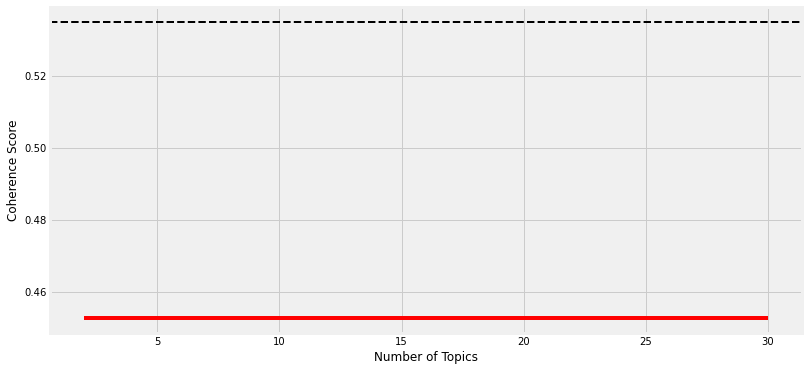

In [41]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

We can retrieve the best model now:

In [42]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

10

Let’s view all the 20 topics generated by our selected best model, similar to our previous models

In [43]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['circuit', 'signal', 'neuron', 'chip', 'motion', 'current', 'voltage', 'analog', 'frequency', 'neural', 'filter', 'response', 'noise', 'channel', 'processing', 'cell', 'velocity', 'implementation', 'sound', 'synapse']

Topic #2:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'unit', 'layer', 'visual', 'synaptic', 'cortical', 'connection', 'firing', 'effect', 'et_al', 'neural', 'cortex', 'simulation', 'map', 'spike']

Topic #3:
['state', 'control', 'action', 'step', 'policy', 'trajectory', 'task', 'controller', 'reinforcement_learning', 'optimal', 'environment', 'robot', 'dynamic', 'goal', 'reward', 'position', 'change', 'agent', 'td', 'current']

Topic #4:
['node', 'structure', 'cluster', 'tree', 'graph', 'clustering', 'variable', 'representation', 'map', 'vector', 'level', 'edge', 'local', 'constraint', 'rule', 'mapping', 'region', 'object', 'approximation', 'part']

Topic #5:
['rate', 'variable', 'spike', 'sample', 'estimate', 'signal', 'feature', 'chann

In [44]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Term1,circuit,neuron,state,node,rate,unit,training,image,class,distribution
Term2,signal,cell,control,structure,variable,training,unit,feature,training,equation
Term3,neuron,response,action,cluster,spike,pattern,vector,object,classifier,state
Term4,chip,stimulus,step,tree,sample,word,layer,pixel,classification,matrix
Term5,motion,activity,policy,graph,estimate,task,net,face,probability,vector
Term6,current,pattern,trajectory,clustering,signal,rule,state,vector,sample,noise
Term7,voltage,unit,task,variable,feature,trained,hidden_unit,representation,distribution,dynamic
Term8,analog,layer,controller,representation,channel,recognition,linear,transformation,kernel,gaussian
Term9,frequency,visual,reinforcement_learning,map,average,layer,neuron,recognition,bound,approximation
Term10,neural,synaptic,optimal,vector,component,feature,architecture,view,test,solution


Another easy way to view the topics is to create a topic-term dataframe, whereby each topic is represented in a row with the terms of the topic being represented as a comma-separated string

In [45]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

<ipython-input-45-8a50780ba5c5>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"circuit, signal, neuron, chip, motion, current, voltage, analog, frequency, neural, filter, response, noise, channel, processing, cell, velocity, implementation, sound, synapse"
Topic2,"neuron, cell, response, stimulus, activity, pattern, unit, layer, visual, synaptic, cortical, connection, firing, effect, et_al, neural, cortex, simulation, map, spike"
Topic3,"state, control, action, step, policy, trajectory, task, controller, reinforcement_learning, optimal, environment, robot, dynamic, goal, reward, position, change, agent, td, current"
Topic4,"node, structure, cluster, tree, graph, clustering, variable, representation, map, vector, level, edge, local, constraint, rule, mapping, region, object, approximation, part"
Topic5,"rate, variable, spike, sample, estimate, signal, feature, channel, average, component, probability, noise, missing, eeg, search, risk, step, density, classification, solution"
Topic6,"unit, training, pattern, word, task, rule, trained, recognition, layer, feature, sequence, architecture, representation, memory, net, hidden_unit, activation, speech, character, level"
Topic7,"training, unit, vector, layer, net, state, hidden_unit, linear, neuron, architecture, recurrent, class, node, hmm, threshold, activation, gradient, mlp, pattern, nonlinear"
Topic8,"image, feature, object, pixel, face, vector, representation, transformation, recognition, view, local, visual, distance, class, linear, classification, scale, training, filter, shape"
Topic9,"class, training, classifier, classification, probability, sample, distribution, kernel, bound, test, prediction, let, size, machine, estimate, loss, linear, training_set, vector, regression"
Topic10,"distribution, equation, state, matrix, vector, noise, dynamic, gaussian, approximation, solution, density, variable, probability, component, theory, linear, eq, step, prior, rule"


# Interpreting Topic Model Results

In [46]:
tm_results = best_lda_model[bow_corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topics[:5]

[(5, 0.46751153),
 (9, 0.4825014),
 (9, 0.4648029),
 (6, 0.8165061),
 (6, 0.64134735)]

This provides a plethora of options that can be leveraged to extract useful insights from our corpus of research papers
<br>
To enable this, we construct a master dataframe that will hold the base statistics, which we use soon to depict different useful insights.

In [47]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

# Dominant Topics Distribution Across Corpus

In [ ]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

# Dominant Topics in Specific Research Papers

In [49]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,8,55.87,"image, feature, object, pixel, face, vector, representation, transformation, recognition, view, local, visual, distance, class, linear, classification, scale, training, filter, shape","622 \nLEARNING A COLOR ALGORITHM FROM EXAMPLES \nAnya C. Hurlbert and Tomaso A. Poggio \nArtificial Intelligence Laboratory and Department of Brain and Cognitive Sciences, \nMassachusetts Institut..."
13,13,7,60.42,"training, unit, vector, layer, net, state, hidden_unit, linear, neuron, architecture, recurrent, class, node, hmm, threshold, activation, gradient, mlp, pattern, nonlinear","534 \nThe Performance of Convex Set Projection Based Neural Networks \nRobert J. Marks II, Les E. Atlas, Seho Oh and James A. Ritcey \nInteractive Systems Design Lab, FT-10 \nUniversity of Washing..."
17,17,6,59.42,"unit, training, pattern, word, task, rule, trained, recognition, layer, feature, sequence, architecture, representation, memory, net, hidden_unit, activation, speech, character, level","652 \nScaling Properties of Coarse-Coded Symbol Memories \nRonald Rosenfeld \nDavid S. Touretzky \nComputer Science Department \nCarnegie Mellon University \nPittsburgh, Pennsylvania 15213 \nAbstr..."
392,392,7,52.24,"training, unit, vector, layer, net, state, hidden_unit, linear, neuron, architecture, recurrent, class, node, hmm, threshold, activation, gradient, mlp, pattern, nonlinear","ART2/BP architecture for adaptive estimation of \ndynamic processes \nEinar Srheim* \nDepartment of Computer Science \nUNIK, Kjeller \nUniversity of Oslo \nN-2007 Norway \nAbstract \nThe goal has..."
503,503,6,51.99,"unit, training, pattern, word, task, rule, trained, recognition, layer, feature, sequence, architecture, representation, memory, net, hidden_unit, activation, speech, character, level","Information Measure Based Skeletonisation \nSowmya Ramachandran \nDepartment of Computer Science \nUniversity of Texas at Austin \nAustin, TX 78712-1188 \nLorien Y. Pratt * \nDepartment of Compute..."
681,681,1,91.31,"circuit, signal, neuron, chip, motion, current, voltage, analog, frequency, neural, filter, response, noise, channel, processing, cell, velocity, implementation, sound, synapse","Analog Cochlear Model for Multiresolution \nSpeech Analysis \nWeimin Liu Andreas G. Andreou and Moise H. Goldstein, Jr. \nDepartment of Electrical and Computer Engineering \nThe Johns Hopkins Uni..."
733,733,10,46.46,"distribution, equation, state, matrix, vector, noise, dynamic, gaussian, approximation, solution, density, variable, probability, component, theory, linear, eq, step, prior, rule",Two Iterative Algorithms for Computing \nthe Singular Value Decomposition from \nInput[Output Samples \nTerence D. Sanger \nJet Propulsion Laboratory \nMS 303-310 \n4800 Oak Grove Drive \nPasadena...
906,906,9,69.62,"class, training, classifier, classification, probability, sample, distribution, kernel, bound, test, prediction, let, size, machine, estimate, loss, linear, training_set, vector, regression","Generalisation in Feedforward Networks \nAdam Kowalczyk and Herman Ferra \nTelecom Australia, Research Laboratories \n770 Blackburn Road, Clayton, Vic. 3168, Australia \n(a.kowalczyk@trl.oz.au, h...."
996,996,10,99.95,"distribution, equation, state, matrix, vector, noise, dynamic, gaussian, approximation, solution, density, variable, probability, component, theory, linear, eq, step, prior, rule","A New Learning Algorithm for Blind \nSignal Separation \nS. Amari* \nUniversity of Tokyo \nBunkyo-ku, Tokyo 113, JAPAN \namari @ sat. t. u- tokyo. ac.j p \nA. Cichocki \nLab. for Artificial Brain ..."
1622,1622,9,52.45,"class, training, classifier, classification, probability, sample, distribution, kernel, bound, test, prediction, let, size, machine, estimate, loss, linear, training_set, vector, regression","Training Data Selection \nfor Optimal Generalization \nin Trigonometric Polynomial Networks \nMasashi Sugiyama*and Hidemitsu Ogawa \nDepartm

# Relevant Research Papers per Topic based on Dominance

In [50]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1032,1,99.97,"circuit, signal, neuron, chip, motion, current, voltage, analog, frequency, neural, filter, response, noise, channel, processing, cell, velocity, implementation, sound, synapse","Improved Silicon Cochlea \nusing \nCompatible Lateral Bipolar Transistors \nAndr6 van Schaik, Eric Fragnire, Eric Vittoz \nMANTRA Center for Neuromimetic Systems \nSwiss Federal Institute of Tech..."
2,1103,2,99.97,"neuron, cell, response, stimulus, activity, pattern, unit, layer, visual, synaptic, cortical, connection, firing, effect, et_al, neural, cortex, simulation, map, spike","Simulation of a Thalamocortical Circuit for \nComputing Directional Heading in the Rat \nHugh T. Blair* \nDepartment of Psychology \nYale University \nNew Haven, CT 06520-8205 \ntadb @minerva. cis..."
3,348,3,99.97,"state, control, action, step, policy, trajectory, task, controller, reinforcement_learning, optimal, environment, robot, dynamic, goal, reward, position, change, agent, td, current","Integrated Modeling and Control \nBased on Reinforcement Learning \nand Dynamic Programming \nRichard S. Sutton \nGTE Laboratories Incorporated \nWaltham, MA 02254 \nAbstract \nThis is a summary o..."
4,384,4,98.41,"node, structure, cluster, tree, graph, clustering, variable, representation, map, vector, level, edge, local, constraint, rule, mapping, region, object, approximation, part","Distributed Pecursive Structure Processing \nGraldine Legendre \nDepartment of \nLinguistics \nYoshiro Miyata \nOptoelectronic \nComputing Systems Center \nUniversity of Colorado \nBoulder, CO 80..."
5,471,5,98.45,"rate, variable, spike, sample, estimate, signal, feature, channel, average, component, probability, noise, missing, eeg, search, risk, step, density, classification, solution","Data Analysis using G/SPLINES \nDavid Rogers \nResearch Institute for Advanced Computer Science \nMS T041-5, NASA/Ames Research Center \nMoffett Field, CA 94035 \nINTERNET: drogersriacs.edu \nAbs..."
6,416,6,99.97,"unit, training, pattern, word, task, rule, trained, recognition, layer, feature, sequence, architecture, representation, memory, net, hidden_unit, activation, speech, character, level","A Recurrent Neural Network for Word Identification \nfrom Continuous Phoneme Strings \nRobert B. Allen \nBellcore \nMorristown, NJ 07962-1910 \nCandace A. Kamm \nBellcore \nMorristown, NJ 07962-19..."
7,632,7,99.97,"training, unit, vector, layer, net, state, hidden_unit, linear, neuron, architecture, recurrent, class, node, hmm, threshold, activation, gradient, mlp, pattern, nonlinear","Computing with Almost Optimal Size Neural \nNetworks \nKai-Yeung Siu \nDept. of Electrical &; Comp. Engineering \nUniversity of California, Irvine \nIrvine, CA 92717 \nVwani Roychowdhury \nSchool ..."
8,1645,8,98.78,"image, feature, object, pixel, face, vector, representation, transformation, recognition, view, local, visual, distance, class, linear, classification, scale, training, filter, shape",Image representations for facial expression \ncoding \nMarian Stewart Bartlett* \nU.C. San Diego \nmarnisalk. edu \nJavier R. Movellan \nU.C. San Diego \nmovellancogsc. ucsd. edu \nPaul Ekman \n...
9,1652,9,99.97,"class, training, classifier, classification, probability, sample, distribution, kernel, bound, test, prediction, let, size, machine, estimate, loss, linear, training_set, vector, regression","v-Arc: Ensemble Learning \nin the Presence of Outliers \nG. Ritsch t, B. Sch51kopf t, A. Smola*, \nK.-R. Miillert, T. Onoda**, and S. Mika* \nt GMD FIRST, Rudower Chaussee 5, 12489 Berlin, German..."


# Predicting Topics for New Research Papers

In [51]:
import glob
# papers manually downloaded from NIPS 16
#https://papers.nips.cc/paper/2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 0


In [52]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

In [ ]:
print(norm_new_papers[0][:30])

In [ ]:
print(norm_bow_features[0][:30])

In [ ]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [ ]:
topic_preds = get_topic_predictions(topic_model=best_lda_model,  corpus=norm_bow_features, topn=2)
topic_preds

In [ ]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

In [ ]:
pd.set_option('display.max_colwidth', 300)
results_df